In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from kernels import *
import pdb
import gpytorch
from itertools import product

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_x = torch.linspace(float(-2), float(2), int(50))
# The original sin/cos data
#one = torch.sin(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.2)
#two = torch.cos(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.02)

# Polynomials + diff(poly) data
#one = torch.pow(train_x, int(3)) + torch.randn(train_x.size()) * float(0.2)
#two = int(3)*torch.pow(train_x, int(2)) + torch.randn(train_x.size()) * float(0.2)

# Combined poly + sin/cos
one = torch.mul(torch.sin(train_x), train_x)+ torch.randn(train_x.size()) * float(0.2)
two = torch.mul(torch.cos(train_x), train_x) + torch.sin(train_x) + torch.randn(train_x.size()) * float(0.2)

# only sin/cos
one = torch.mul(torch.sin(train_x), torch.cos(train_x)) + torch.randn(train_x.size()) * float(0.2)
two = torch.mul(torch.cos(train_x), torch.cos(train_x)) - torch.mul(torch.sin(train_x), torch.sin(train_x)) + torch.randn(train_x.size()) * float(0.2)


train_y = torch.stack([one, two], int(-1))


In [3]:
train_y
# = torch.Tensor([[float(-0.3), float(0.99)],[float(-0.07), float(1.01)]])

tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.4742],
        [ 0.4472, -0.2068],
        [ 0.6645, -0

In [4]:

len(train_y.shape)

2

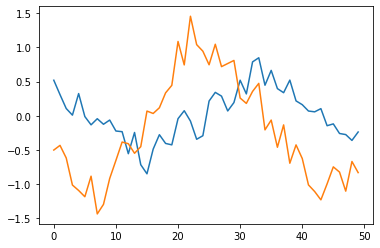

In [5]:
plt.plot(train_y)

$$
\begin{align}
L =& 
\left[
\begin{matrix}
1 & dx_1 \\
0 & 1
\end{matrix}
\right]\\
R =& 
\left[
\begin{matrix}
1 & 0\\
dx_2 & 1
\end{matrix}
\right]\\
\hat{k} =& 
\left[
\begin{matrix}
SE_1 & 0\\
0 & SE_2
\end{matrix}
\right]\\
k =& L*\hat{k}*R\\
=& \left[
\begin{matrix}
dx_1 dx_2 SE_2 + SE_1 & dx_1 SE_2\\
dx_2 SE_2 & SE_2
\end{matrix}
\right]
\end{align}
$$

In [6]:
dx1, dx2, k1, k2, f, g = var('dx1, dx2, k1, k2, f, g')
K = matrix(2,2, (k1, 0, 0, 0))
L = matrix(2, 2, (1, 0, dx1, 1))
R = matrix(2, 2, (1, dx2, 0, 1))
L*K*R
# used to see how the data should be created if I 
# decide to create it exactly as I create the kernel
#K = matrix(2,1, (f, g))
#L*L*K

[        k1     dx2*k1]
[    dx1*k1 dx1*dx2*k1]

In [7]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=2
        )
        kernel = Diff_SE_kernel(var=0, length=0)
        #kernel2 = Diff_SE_kernel(var=0, length=0)
        q, dx1, dx2 = var('q, dx1, dx2')
        L = matrix(2, 2, (1, 0, dx1, 1))
        R = matrix(2, 2, (1, dx2, 0, 1))
        p = DiffMatrixKernel([[kernel, None], [None, None]])
        self.covar_module = p.diff(left_matrix=L, right_matrix=R)
        
        #kernel0 = gpytorch.kernels.RBFKernel()
        #kernel1 = gpytorch.kernels.RBFKernel()
        #kernel2 = gpytorch.kernels.RBFKernel()
        #kernel0 = Diff_SE_kernel(var = 0, length=0)
        #kernel1 = Diff_SE_kernel(var = 0, length=0)
        #kernel2 = Diff_SE_kernel(var = 0, length=0)
        #self.covar_module = MatrixKernel([[kernel0, None], [None, kernel2]])

    def forward(self, x):
        #pdb.set_trace()
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        #print(f"{covar_x.detach().evaluate()}")
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x, validate_args=True)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
#likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2, has_global_noise=False, has_task_noise=False)
#likelihood._set_task_noises(torch.Tensor([float(0.0001),float(0.0001)]))
#likelihood._set_noise(torch.tensor(float(0.0001)))
model = MultitaskGPModel(train_x, train_y, likelihood)

List of all kernels: [Diff_SE_kernel()]
[[diffed_SE_kernel(), diffed_SE_kernel()], [diffed_SE_kernel(), diffed_SE_kernel()]]


In [8]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = int(2) if smoke_test else int(75)


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=float(0.1))  # Includes GaussianLikelihood parameters


# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

param_dict = {p[0]:[] for p in model.named_parameters() if 'covar' in p[0]}
param_dict['loss'] = []
param_dict['noise'] = []
if len(likelihood.task_noises) > 1:
    param_dict['task_noises'] = [[] for i in range(len(likelihood.task_noises))]
for p in model.named_parameters():
    if 'covar' in p[0]:
        param_dict[f"{p[0]}_grad"] = []

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    print(output)
    print(train_y)
    loss = -mll(output, train_y)
    param_dict['loss'].append(loss.item())
    #pdb.set_trace()
    loss.backward()
    for parameter in model.named_parameters():
        if 'covar' in parameter[0]:
            param_dict[parameter[0]].append(parameter[1].item())
            param_dict[f"{parameter[0]}_grad"].append(parameter[1].grad.item())
    param_dict['noise'].append(likelihood.noise.item())
    for l in range(len(likelihood.task_noises)):
        param_dict['task_noises'][l].append(likelihood.task_noises[l].item())
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f  variance: %.3f noise: %.3f' % (
    #    i + 1, training_iter, loss.item(),
    #    model.covar_module.length.item(),
    #    model.covar_module.var.item(),
    #    model.likelihood.noise.item()
    #))
    optimizer.step()

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

MultitaskMultivariateNormal(loc: torch.Size([100]))
tensor([[ 0.5204, -0.5027],
        [ 0.3095, -0.4342],
        [ 0.1060, -0.6183],
        [ 0.0087, -1.0153],
        [ 0.3248, -1.0948],
        [-0.0119, -1.1867],
        [-0.1331, -0.8856],
        [-0.0436, -1.4384],
        [-0.1248, -1.2984],
        [-0.0631, -0.9190],
        [-0.2237, -0.6547],
        [-0.2335, -0.3852],
        [-0.5561, -0.4095],
        [-0.2452, -0.5498],
        [-0.7174, -0.4532],
        [-0.8506,  0.0684],
        [-0.4889,  0.0334],
        [-0.2777,  0.1171],
        [-0.4057,  0.3355],
        [-0.4265,  0.4454],
        [-0.0432,  1.0883],
        [ 0.0737,  0.7449],
        [-0.0782,  1.4578],
        [-0.3446,  1.0418],
        [-0.2927,  0.9457],
        [ 0.2155,  0.7469],
        [ 0.3424,  1.0475],
        [ 0.2874,  0.7197],
        [ 0.0700,  0.7650],
        [ 0.1932,  0.8103],
        [ 0.5207,  0.2597],
        [ 0.3198,  0.1808],
        [ 0.7890,  0.3562],
        [ 0.8496,  0.474

In [9]:
param_dict

{'covar_module.13084026144.var': [0.0,
  -0.09999994188547134,
  -0.197261244058609,
  -0.28733062744140625,
  -0.3685597777366638,
  -0.4435499310493469,
  -0.5165376663208008,
  -0.5912648439407349,
  -0.6697278618812561,
  -0.7522299289703369,
  -0.8381127715110779,
  -0.9262163043022156,
  -1.014909029006958,
  -1.1019086837768555,
  -1.184169888496399,
  -1.2582660913467407,
  -1.3215218782424927,
  -1.3731689453125,
  -1.414454698562622,
  -1.4478237628936768,
  -1.4759266376495361,
  -1.5008175373077393,
  -1.523415446281433,
  -1.5432754755020142,
  -1.5586856603622437,
  -1.5671144723892212,
  -1.5660789012908936,
  -1.5542502403259277,
  -1.5321487188339233,
  -1.5019766092300415,
  -1.4668989181518555,
  -1.4301835298538208,
  -1.3943430185317993,
  -1.3604998588562012,
  -1.3282718658447266,
  -1.296279788017273,
  -1.2631595134735107,
  -1.228683590888977,
  -1.1942895650863647,
  -1.1626002788543701,
  -1.1361916065216064,
  -1.1163268089294434,
  -1.10245943069458,
  -1.

In [10]:
for parameter in model.named_parameters():
    print(parameter)

('likelihood.raw_task_noises', Parameter containing:
tensor([-4.4542, -3.5186], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([-4.0191], requires_grad=True))
('covar_module.13084026144.var', Parameter containing:
tensor(-1.1992, requires_grad=True))
('covar_module.13084026144.length', Parameter containing:
tensor(-0.0292, requires_grad=True))


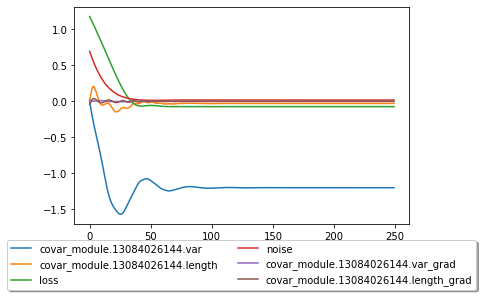

In [11]:
for param_key in param_dict:
    if param_key == 'task_noises':
        pass
    else:
        plt.plot(param_dict[param_key], label=param_key)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)


In [12]:
print(likelihood.noise)
print(likelihood.task_noises)

tensor([0.0179], grad_fn=<AddBackward0>)
tensor([0.0117, 0.0293], grad_fn=<AddBackward0>)


In [13]:
A = matrix(QQ, 4, 4, (2,0,0.6065,0.6065,0,1,-0.6065,0.6065,0.6065,-0.6065,2,0,0.6065,0.6065,0,1))
L = A.cholesky()
L*L.transpose()

[  2.000000000000000?                    0  0.6065000000000000?  0.6065000000000000?]
[                   0                    1 -0.6065000000000000?  0.6065000000000000?]
[ 0.6065000000000000? -0.6065000000000000?   2.000000000000000?              0.?e-18]
[ 0.6065000000000000?  0.6065000000000000?              0.?e-18   1.000000000000000?]

In [14]:
for parameter in model.named_parameters():
    print(parameter)

('likelihood.raw_task_noises', Parameter containing:
tensor([-4.4542, -3.5186], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([-4.0191], requires_grad=True))
('covar_module.13084026144.var', Parameter containing:
tensor(-1.1992, requires_grad=True))
('covar_module.13084026144.length', Parameter containing:
tensor(-0.0292, requires_grad=True))


In [15]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots

number_of_samples = int(75)
# Make predictions
with torch.no_grad():#, gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(float(-2), float(4), number_of_samples)
    #pdb.set_trace()
    outputs = model(test_x)
    predictions = likelihood(outputs)
    
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
#print(mean)
#print(lower)
#print(upper)
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

#dims = int(2)
#indices = [list(range(i, len(train_y), dims)) for i in range(dims)]


tensor([[ 3.0145e-01,  0.0000e+00,  3.0038e-01,  ..., -3.6581e-04,
          6.2517e-05, -2.6510e-04],
        [ 0.0000e+00,  3.1957e-01,  2.5995e-02,  ..., -1.4262e-03,
          2.6510e-04, -1.0579e-03],
        [ 3.0038e-01,  2.5995e-02,  3.0145e-01,  ..., -5.0101e-04,
          8.8065e-05, -3.6581e-04],
        ...,
        [-3.6581e-04, -1.4262e-03, -5.0101e-04,  ...,  3.1957e-01,
          2.5995e-02,  3.1619e-01],
        [ 6.2517e-05,  2.6510e-04,  8.8065e-05,  ...,  2.5995e-02,
          3.0145e-01,  0.0000e+00],
        [-2.6510e-04, -1.0579e-03, -3.6581e-04,  ...,  3.1619e-01,
          0.0000e+00,  3.1957e-01]])
tensor([[ 3.0145e-01,  0.0000e+00,  3.0038e-01,  ..., -1.6295e-08,
          1.5559e-09, -9.8967e-09],
        [ 0.0000e+00,  3.1957e-01,  2.5995e-02,  ..., -9.9492e-08,
          9.8967e-09, -6.1301e-08],
        [ 3.0038e-01,  2.5995e-02,  3.0145e-01,  ..., -2.6726e-08,
          2.6059e-09, -1.6350e-08],
        ...,
        [-1.6295e-08, -9.9492e-08, -2.6726e-08

Text(0.5, 1.0, 'Observed Values (Likelihood)')

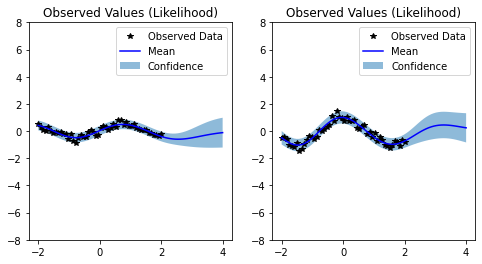

In [16]:
f, (y1_ax, y2_ax) = plt.subplots(int(1), int(2), figsize=(int(8), int(4)))

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-8, 8])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-8, 8])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')


In [17]:
a = matrix(1, 2, (1, 2))
b = matrix(2, 2, (1, 2, 3, 4))
a*b

[ 7 10]

# Test Diffable SE Kernel

In [18]:
X = torch.tensor([int(1), int(2), int(3)])
X

tensor([1, 2, 3])

In [19]:
x1, x2, l, sigma = var('x1, x2, l, sigma')
lengthscale = 1
variance = 1
SE(x1, x2, l, sigma) = sigma^2*exp(-(x1-x2)^2/(2*l^2))
cov_matr = [[None for i in range(len(X))] for j in range(len(X))]
for i, (v1, v2) in enumerate(product(X, X)):
    cov_matr[int(i/len(X))][int(i%len(X))] = float(SE.diff(x2).diff(x1)(int(v1), int(v2), lengthscale, variance))
cov_matr

[[1.0, 0.0, -0.4060058497098381],
 [0.0, 1.0, 0.0],
 [-0.4060058497098381, 0.0, 1.0]]

In [20]:
print(SE.diff(x1))
print(SE.diff(x1).diff(x2))

(x1, x2, l, sigma) |--> -sigma^2*(x1 - x2)*e^(-1/2*(x1 - x2)^2/l^2)/l^2
(x1, x2, l, sigma) |--> sigma^2*e^(-1/2*(x1 - x2)^2/l^2)/l^2 - sigma^2*(x1 - x2)^2*e^(-1/2*(x1 - x2)^2/l^2)/l^4


In [21]:
a = Diff_SE_kernel(var=int(variance), length=int(lengthscale))
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx2
right_poly = dx1 
diffed_kernel = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
left_poly = dx2
right_poly = 1
diffed_kernel2 = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
diffed_kernel(X).evaluate() + diffed_kernel2(X).evaluate()

tensor([[ 0.3679,  0.6411,  0.6900],
        [-0.0465,  0.3679,  0.6411],
        [-0.4326, -0.0465,  0.3679]], grad_fn=<AddBackward0>)

In [22]:
def calc_cell_diff(L, M, R, context=None):
    len_M = np.shape(M)[0]
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
       map(list, itertools.zip_longest(*M, fillvalue=None)))
    for r_elem, row_M in zip(R, M_transpose):
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                if m_elem is not None:
                    temp = l_elem * m_elem*r_elem
                    #temp = l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
            else:
                if m_elem is not None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                    temp += l_elem * m_elem*r_elem
                    #temp += l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
    return temp.simplify_full()


In [23]:
dimension = 3
length = dimension*dimension +1
L_list = [var(f'l_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
M_list = [var(f'm_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
R_list = [var(f'r_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
L = matrix(dimension, dimension, L_list)
M = matrix(dimension, dimension, M_list)
R = matrix(dimension, dimension, R_list)
print(L)
print(M)
print(R)
row = 0
col = 0
for row in range(dimension):
    for col in range(dimension):
        print((L*M*R)[row][col])
print("\n\n")
for i, (l, r) in enumerate(itertools.product(L.rows(), R.columns())):

    print(calc_cell_diff(l, M, r))
    print("\n")

[l_11 l_12 l_13]
[l_21 l_22 l_23]
[l_31 l_32 l_33]
[m_11 m_12 m_13]
[m_21 m_22 m_23]
[m_31 m_32 m_33]
[r_11 r_12 r_13]
[r_21 r_22 r_23]
[r_31 r_32 r_33]
(l_11*m_11 + l_12*m_21 + l_13*m_31)*r_11 + (l_11*m_12 + l_12*m_22 + l_13*m_32)*r_21 + (l_11*m_13 + l_12*m_23 + l_13*m_33)*r_31
(l_11*m_11 + l_12*m_21 + l_13*m_31)*r_12 + (l_11*m_12 + l_12*m_22 + l_13*m_32)*r_22 + (l_11*m_13 + l_12*m_23 + l_13*m_33)*r_32
(l_11*m_11 + l_12*m_21 + l_13*m_31)*r_13 + (l_11*m_12 + l_12*m_22 + l_13*m_32)*r_23 + (l_11*m_13 + l_12*m_23 + l_13*m_33)*r_33
(l_21*m_11 + l_22*m_21 + l_23*m_31)*r_11 + (l_21*m_12 + l_22*m_22 + l_23*m_32)*r_21 + (l_21*m_13 + l_22*m_23 + l_23*m_33)*r_31
(l_21*m_11 + l_22*m_21 + l_23*m_31)*r_12 + (l_21*m_12 + l_22*m_22 + l_23*m_32)*r_22 + (l_21*m_13 + l_22*m_23 + l_23*m_33)*r_32
(l_21*m_11 + l_22*m_21 + l_23*m_31)*r_13 + (l_21*m_12 + l_22*m_22 + l_23*m_32)*r_23 + (l_21*m_13 + l_22*m_23 + l_23*m_33)*r_33
(l_31*m_11 + l_32*m_21 + l_33*m_31)*r_11 + (l_31*m_12 + l_32*m_22 + l_33*m_32)*r_21 +

In [24]:
def calc_cell_diff_sage(L, M, R, context=None):
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
        map(list, itertools.zip_longest(*M, fillvalue=None)))
    # Every row in 'M' is combined with each elem of the row given in 'R'
    # Or: For each elemtn in row 'R' combine with 'row_M'
    for r_elem, row_M in zip(R, M_transpose):
        # Each element in L gets exactly one element in 'row_M' to multiply
        # Or: Combine each element in row_M with exactly one element in 'L'
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp = m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp = m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp = m_elem.diff(l_elem)
                else:
                    pass
            else:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp += m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp += m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp += m_elem.diff(l_elem)
                    
                else:
                    pass
    return temp

def diff_sage(matrix, left_matrix=None, right_matrix=None):
    # iterate left matrix by rows and right matrix by columns and call the
    # respective diff command of the kernels with the row/cols as params
    kernel = MatrixKernel(None)
    output_matrix = [[0 for i in range(np.shape(matrix)[1])] for j in range(np.shape(matrix)[0])]
    for i, (l, r) in enumerate(itertools.product(left_matrix.rows(), right_matrix.columns())):
        res = calc_cell_diff_sage(l, matrix, r, context=kernel)
        output_matrix[int(i/np.shape(matrix)[0])][
                    int(i % np.shape(matrix)[0])]  = res
    kernel.set_matrix(output_matrix)
    return output_matrix


In [25]:
import pprint
L = matrix(2, 2, (x1, x1, 0, x1))
R = matrix(2, 2, (x2, 0, x2, x2))
x1, x2, l, sigma = var('x1, x2, l, sigma')
lengthscale = 1
variance = 1
SEKernelMatrix = [[sigma^2*exp(-(x1-x2)^2/(2*l^2)), None], [None, sigma^2*exp(-(x1-x2)^2/(2*l^2))]]
diffed_SE_sage_matrix_kernel = diff_sage(SEKernelMatrix, left_matrix=L, right_matrix=R)
pprint.pprint(diffed_SE_sage_matrix_kernel)
cov_matr = [[None for i in range(len(X)*len(diffed_SE_sage_matrix_kernel))] for j in range(len(X)*len(diffed_SE_sage_matrix_kernel))]
for i, (v1, v2) in enumerate(product(X, X)):
    for row in range(len(diffed_SE_sage_matrix_kernel)):
        for col in range(len(diffed_SE_sage_matrix_kernel)):
            # Blockwise
            cov_matr[int(i/len(X))+row*len(X)][int(i%len(X))+col*len(X)] = diffed_SE_sage_matrix_kernel[row][col].substitute(x1=int(v1), x2=int(v2), l=lengthscale, sigma=variance)
            # Interleaved
            #cov_matr[int(((i*len(diffed_SE_sage_matrix_kernel))+row)/(len(X)*len(diffed_SE_sage_matrix_kernel)))*2+row][int((i*len(diffed_SE_sage_matrix_kernel))+col)%(len(X)*len(diffed_SE_sage_matrix_kernel))] = float(diffed_SE_sage_matrix_kernel[row][col].substitute(x1=int(v1), x2=int(v2), l=lengthscale, sigma=variance))
cov_matr


[[2*sigma^2*e^(-1/2*(x1 - x2)^2/l^2)/l^2 - 2*sigma^2*(x1 - x2)^2*e^(-1/2*(x1 - x2)^2/l^2)/l^4,
  sigma^2*e^(-1/2*(x1 - x2)^2/l^2)/l^2 - sigma^2*(x1 - x2)^2*e^(-1/2*(x1 - x2)^2/l^2)/l^4],
 [sigma^2*e^(-1/2*(x1 - x2)^2/l^2)/l^2 - sigma^2*(x1 - x2)^2*e^(-1/2*(x1 - x2)^2/l^2)/l^4,
  sigma^2*e^(-1/2*(x1 - x2)^2/l^2)/l^2 - sigma^2*(x1 - x2)^2*e^(-1/2*(x1 - x2)^2/l^2)/l^4]]


[[2, 0, -6*e^(-2), 1, 0, -3*e^(-2)],
 [0, 2, 0, 0, 1, 0],
 [-6*e^(-2), 0, 2, -3*e^(-2), 0, 1],
 [1, 0, -3*e^(-2), 1, 0, -3*e^(-2)],
 [0, 1, 0, 0, 1, 0],
 [-3*e^(-2), 0, 1, -3*e^(-2), 0, 1]]

In [26]:

kernel = Diff_SE_kernel()
kernel2 = Diff_SE_kernel()
q, dx1, dx2 = var('q, dx1, dx2')
L = matrix(2, 2, (dx1, dx1, 0, dx1))
R = matrix(2, 2, (dx2, 0, dx2, dx2))

p = DiffMatrixKernel([[kernel, None], [None, kernel2]])
covar_module = p.diff(left_matrix=L, right_matrix=R)

covar_x = covar_module(X)
covar_x.evaluate()

List of all kernels: [Diff_SE_kernel(), Diff_SE_kernel()]
[[AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
), AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
)], [AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
), AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
)]]
tensor([[0.7358, 0.3679, 0.5946, 0.2973, 0.2574, 0.1287],
        [0.3679, 0.3679, 0.2973, 0.2973, 0.1287, 0.1287],
        [0.5946, 0.2973, 0.7358, 0.3679, 0.5946, 0.2973],
        [0.2973, 0.2973, 0.3679, 0.3679, 0.2973, 0.2973],
        [0.2574, 0.1287, 0.5946, 0.2973, 0.7358, 0.3679],
        [0.1287, 0.1287, 0.2973, 0.2973, 0.3679, 0.3679]],
       grad_fn=<CatBackward>)


tensor([[0.7358, 0.3679, 0.5946, 0.2973, 0.2574, 0.1287],
        [0.3679, 0.3679, 0.2973, 0.2973, 0.1287, 0.1287],
        [0.5946, 0.2973, 0.7358, 0.3679, 0.5946, 0.2973],
        [0.2973, 0.2973, 0.3679, 0.3679, 0.2973, 0.2973],
        [0.2574, 0.1287, 0.5946, 0.2973, 0.7358, 0.3679],
        [0.1287, 0.1287, 0.2973, 0.2973, 0.3679, 0.3679]],
       grad_fn=<CatBackward>)

In [27]:
matr = [[2, 0, -6*e^(-2), 1, e^(-1/2), -e^(-2)],
 [0, 2, 0, -e^(-1/2), 1, e^(-1/2)],
 [-6*e^(-2), 0, 2, -5*e^(-2), -e^(-1/2), 1],
 [1, e^(-1/2), -e^(-2), 1, 0, -3*e^(-2)],
 [-e^(-1/2), 1, e^(-1/2), 0, 1, 0],
 [-5*e^(-2), -e^(-1/2), 1, -3*e^(-2), 0, 1]]

matr = [[2, 0, -6*e^(-2), 1, 0, -3*e^(-2)],
 [0, 2, 0, 0, 1, 0],
 [-6*e^(-2), 0, 2, -3*e^(-2), 0, 1],
 [1, 0, -3*e^(-2), 1, 0, -3*e^(-2)],
 [0, 1, 0, 0, 1, 0],
 [-3*e^(-2), 0, 1, -3*e^(-2), 0, 1]]

matr = torch.Tensor(matr)
import pprint
pprint.pprint(matr)
print(matr[0::3, 0::3])
H_x = 3
torch.vstack([torch.hstack([matr[k::H_x, l::H_x] for l in range(H_x)]) for k in range(H_x)])

tensor([[ 2.0000,  0.0000, -0.8120,  1.0000,  0.0000, -0.4060],
        [ 0.0000,  2.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [-0.8120,  0.0000,  2.0000, -0.4060,  0.0000,  1.0000],
        [ 1.0000,  0.0000, -0.4060,  1.0000,  0.0000, -0.4060],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [-0.4060,  0.0000,  1.0000, -0.4060,  0.0000,  1.0000]])
tensor([[2., 1.],
        [1., 1.]])


tensor([[ 2.0000,  1.0000,  0.0000,  0.0000, -0.8120, -0.4060],
        [ 1.0000,  1.0000,  0.0000,  0.0000, -0.4060, -0.4060],
        [ 0.0000,  0.0000,  2.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000],
        [-0.8120, -0.4060,  0.0000,  0.0000,  2.0000,  1.0000],
        [-0.4060, -0.4060,  0.0000,  0.0000,  1.0000,  1.0000]])

In [28]:
class testobject():
    def __init__(self, val):
        self.val = val
    
    def setVal(self, val):
        self.val = val
        
    def printVal(self):
        return self.val
    
    def __call__(self):
        return self.val

In [29]:
t1 = testobject(42)
t2 = testobject(21)
t3 = testobject(17)
l = [[t1, t2], [t2, t3]]
print(l)
t2.setVal(170)
print(l[0][1].printVal())
print(l[1][0].printVal())

[[<__main__.testobject object at 0x311c12b20>, <__main__.testobject object at 0x311c12520>], [<__main__.testobject object at 0x311c12520>, <__main__.testobject object at 0x311c12f40>]]
170
170


In [30]:
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx1
right_poly = dx2
L = matrix(2, 2, (dx1, 0, 0, dx1))
R = matrix(2, 2, (dx2, 0, 0, dx2))

In [31]:
p.diff(left_matrix=L, right_matrix=R).forward(X, X)

[[AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
), AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
)], [AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
), AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
)]]
tensor([[0.3679, 0.0000, 0.2973, 0.0000, 0.1287, 0.0000],
        [0.0000, 0.3679, 0.0000, 0.2973, 0.0000, 0.1287],
        [0.2973, 0.0000, 0.3679, 0.0000, 0.2973, 0.0000],
        [0.0000, 0.2973, 0.0000, 0.3679, 0.0000, 0.2973],
        [0.1287, 0.0000, 0.2973, 0.0000, 0.3679, 0.0000],
        [0.0000, 0.1287, 0.0000, 0.2973, 0.0000, 0.3679]],
       grad_fn=<CatBackward>)


tensor([[0.3679, 0.0000, 0.2973, 0.0000, 0.1287, 0.0000],
        [0.0000, 0.3679, 0.0000, 0.2973, 0.0000, 0.1287],
        [0.2973, 0.0000, 0.3679, 0.0000, 0.2973, 0.0000],
        [0.0000, 0.2973, 0.0000, 0.3679, 0.0000, 0.2973],
        [0.1287, 0.0000, 0.2973, 0.0000, 0.3679, 0.0000],
        [0.0000, 0.1287, 0.0000, 0.2973, 0.0000, 0.3679]],
       grad_fn=<CatBackward>)

In [32]:
w, q, dx1, dx2 = var('w, q, dx1, dx2')
a = dx1^2
#a.degree(dx1)
a.operands()

[dx1, 2]

In [33]:
prod([1,2,3])

6

In [34]:
a = torch.Tensor([[int(1), int(2), int(3)], [int(4), int(5), int(6)], [int(7), int(8), int(9)]])
for i, row in enumerate(a):
    for j, elem in enumerate(row[i:]):
        print(f"row: {i}, col: {i+j}")
        print(elem)

row: 0, col: 0
tensor(1.)
row: 0, col: 1
tensor(2.)
row: 0, col: 2
tensor(3.)
row: 1, col: 1
tensor(5.)
row: 1, col: 2
tensor(6.)
row: 2, col: 2
tensor(9.)


In [35]:
a, b, c, d = var('a, b, c, d')
A = matrix(2,2, (a, b, c, d))
B = matrix(2, 2, (dx1, dx1, 0, dx1))
C = matrix(2, 2, (dx2, 0, dx2, dx2))
print(A)
print(B)
B*A

[a b]
[c d]
[dx1 dx1]
[  0 dx1]


[a*dx1 + c*dx1 b*dx1 + d*dx1]
[        c*dx1         d*dx1]

In [36]:
x = ['a', 'b', 'c']
y = x                 # x and y reference the same object
z = ['a', 'b', 'c']   # x and z reference different objects
#z


print(x is z)
z = x
print(x is z)


False
True
